In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib.ticker as mticker
import matplotlib.dates as mdate

from datetime import datetime, date
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
values = []
with open('/Users/marlis/Developer/SLI/Sea-Level-Indicators/ref_files/akiko_colorscale.txt', 'r') as f:
   lines = f.readlines()
   for line in lines:
      vals = line.split()
      row = [float(v)/256 for v in vals]
      row.append(1)
      values.append(row)
my_cmap = colors.ListedColormap(values, name='my_colormap_name')

In [3]:
'''
TOPEX/Poseidon -> Jason-1:  			14 May 2002
Jason-1 -> Jason-2:						12 Jul 2008
Jason-2 -> Jason-3:						18 Mar 2016
Jason-3 -> Sentinel-6 Michael Freilich:	07 Apr 2022
'''
topex = (date(1992,1,1), date(2002,5,14))
j1 = (date(2002,5,14), date(2008,7,12))
j2 = (date(2008,7,12), date(2016,3,18))
j3 = (date(2016,3,18), date(2022,4,7))
s6 = (date(2022,4,7), date.today())

def date_sat_map(date):
    if date >= topex[0] and date < topex[1]:
        return 'TOPEX/Poseidon'
    if date >= j1[0] and date < j1[1]:
        return 'Jason-1'
    if date >= j2[0] and date < j2[1]:
        return 'Jason-2'
    if date >= j3[0] and date < j3[1]:
        return 'Jason-3'
    if date >= s6[0] and date < s6[1]:
        return 'Sentinel-6 Michael Freilich'

In [4]:
def plot_orth(enso_ds, date, satellite, outdir, vmin=-180, vmax=180):
    date_str = datetime.strftime(date, '%b %d %Y').upper()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-150, 10))
    ax.pcolormesh(enso_ds.longitude, enso_ds.latitude, enso_ds.SSHA, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=my_cmap, shading='nearest')
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.75,zorder=12)
    gl.xlocator = mticker.FixedLocator([])
    gl.ylocator = mticker.FixedLocator([0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.set_facecolor('black')
    fig.text(-.1, 1.02, date_str, color='white', ha='left', va='top', size=20, transform=ax.transAxes)
    if satellite == 'Sentinel-6 Michael Freilich':
        fig.text(1.1, 1.02, satellite.split(' ')[0], color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)
        fig.text(1.1, 0.98, satellite.split('Sentinel-6 ')[-1], color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)
    else:
        fig.text(1.1, 1.02, satellite, color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)

    outpath = f'{outdir}/ENSO_ortho/ENSO_ortho_{str(date).replace("-","")}.png'
    plt.savefig(outpath, bbox_inches='tight', pad_inches=0.5)

def plot_orth_ind(enso_ds, ind_ds, date, satellite):
    date_str = datetime.strftime(date, '%b %d %Y').upper()
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(-150, 10))
    ax.pcolormesh(enso_ds.longitude, enso_ds.latitude, enso_ds.SSHA, transform=ccrs.PlateCarree(), vmin=-180, vmax=180, cmap=my_cmap, shading='nearest')
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.75,zorder=12)
    gl.xlocator = mticker.FixedLocator([])
    gl.ylocator = mticker.FixedLocator([0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.set_facecolor('black')
    ax.text(-.1, 1.02, date_str, color='white', ha='left', va='top', size=20, transform=ax.transAxes)
    if satellite == 'Sentinel-6 Michael Freilich':
        ax.text(1.1, 1.02, satellite.split(' ')[0], color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)
        ax.text(1.1, 0.98, satellite.split('Sentinel-6 ')[-1], color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)
    else:
        ax.text(1.1, 1.02, satellite, color='white', ha='right', va='top', size=20, transform=ax.transAxes, wrap=True)

    ax2 = fig.add_subplot(1,2,2, adjustable='box', aspect=800)
    ax2.set_facecolor('black')
    ax2.plot([datetime(1992,1,1), datetime(2024,1,1)],[0,0], linewidth=3, alpha=0.5)
    ax2.plot(ind_ds.time, ind_ds.enso_index, linewidth=3, color='white')
    ax2.grid()
    ax2.set_xlim([datetime(1992,1,1), datetime(2024,1,1)])
    ax.xaxis.set_major_locator(mdate.YearLocator())
    plt.xticks(color='white', size=14)
    plt.yticks(color='white', size=14)
    plt.ylabel('El Niño Index', color='white', size=16)

    point = ind_ds.sel(time=date.ctime())
    ax2.scatter(point.time.values, point.enso_index, s=175, color='red', zorder=18)
    ax2.scatter(point.time.values, point.enso_index, s=50, color='pink', zorder=19)
    ax2.set_title('El Niño-Southern Oscilliation', color='white', size=20)
    plt.savefig(f'ENSO_ind_{str(date).replace("-","")}.png', bbox_inches='tight', pad_inches=0.5)

    # plt.show()

def plot_plate(enso_ds, date, satellite, outdir, vmin=-180, vmax=180):
    date_str = datetime.strftime(date, '%b %d %Y').upper()

    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(-180))
    g=plt.pcolormesh(enso_ds.longitude, enso_ds.latitude, enso_ds.SSHA, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=my_cmap)
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=.5, linestyle='--', zorder=15)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator([40, 80, 120, 160, -160, -120, -80, -40])
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.xaxis.set_minor_formatter(LONGITUDE_FORMATTER)
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    plt.title(f'{satellite} Sea Level Residuals {date_str}', size=16)
    cb = plt.colorbar(g, orientation="horizontal", shrink=0.5, aspect=30, pad=0.1)
    cb.set_label('MM', fontsize=14)
    cb.ax.tick_params(labelsize=12) 
    fig.tight_layout()

    outpath = f'{outdir}/ENSO_plate/ENSO_plate_{str(date).replace("-","")}.png'
    plt.savefig(outpath, bbox_inches='tight', pad_inches=0.5)


In [5]:
# REQUIRES simple-gridder ENV
def plot_orth_enso(enso_ds, date, satellite, outdir, vmin=-180, vmax=180):
    date_str = datetime.strftime(date, '%d %b %Y')
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(-150, 10))
    ax.pcolormesh(enso_ds.longitude, enso_ds.latitude, enso_ds.SSHA, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=my_cmap, shading='nearest')
    ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
    ax.coastlines(zorder=11)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.75,zorder=12)
    gl.xlocator = mticker.FixedLocator([])
    gl.ylocator = mticker.FixedLocator([0])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    fig.set_facecolor('black')
    fig.text(.6375, 1, date_str, color='white', ha='right', va='bottom', transform=ax.transAxes, fontname='Arial', fontsize=52)
    
    ax.set_ylim(-3000000,2000000)
    fig.tight_layout()    

    outpath = f'{outdir}/ENSO_zoom/ENSO_ortho_zoom_{str(date).replace("-","")}.png'
    # plt.savefig(outpath, bbox_inches='tight', pad_inches=.75)
    fig.savefig(outpath, bbox_inches='tight', pad_inches=.75)
    # plt.savefig(outpath, bbox_inches='tight', pad_inches=.75)
    print(plt.gcf().get_dpi())
    

2023-11-06


/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = li

2023-11-13


/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = li

2023-11-20


/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = li

2023-11-27


/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/marlis/opt/anaconda3/envs/sli-pipeline/lib/python3.7/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = li

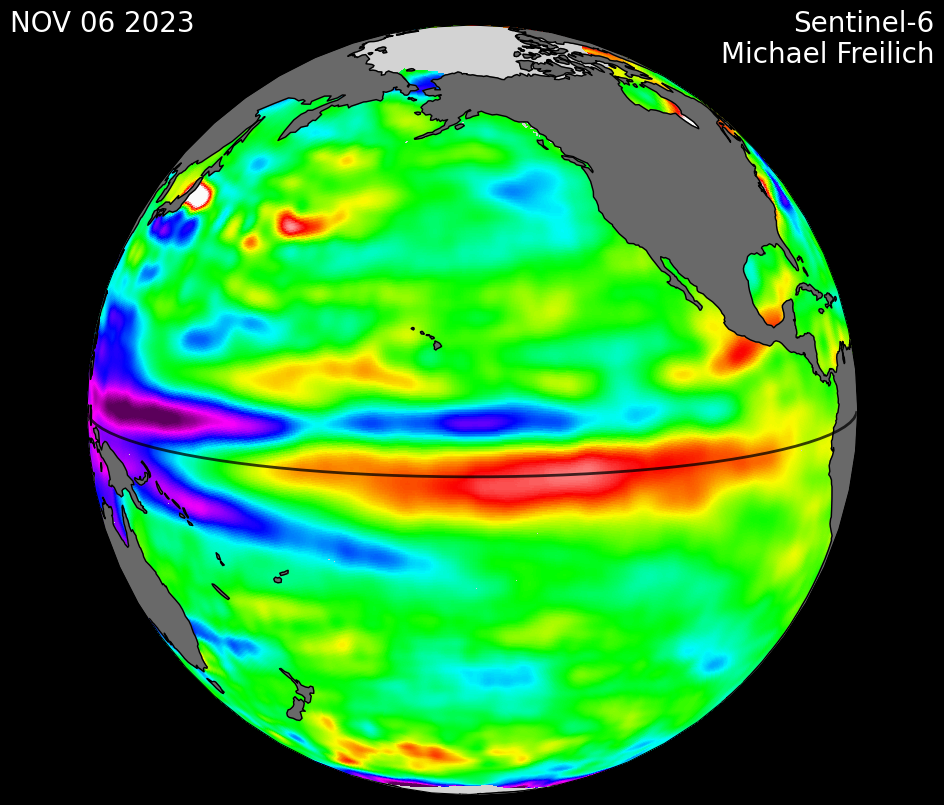

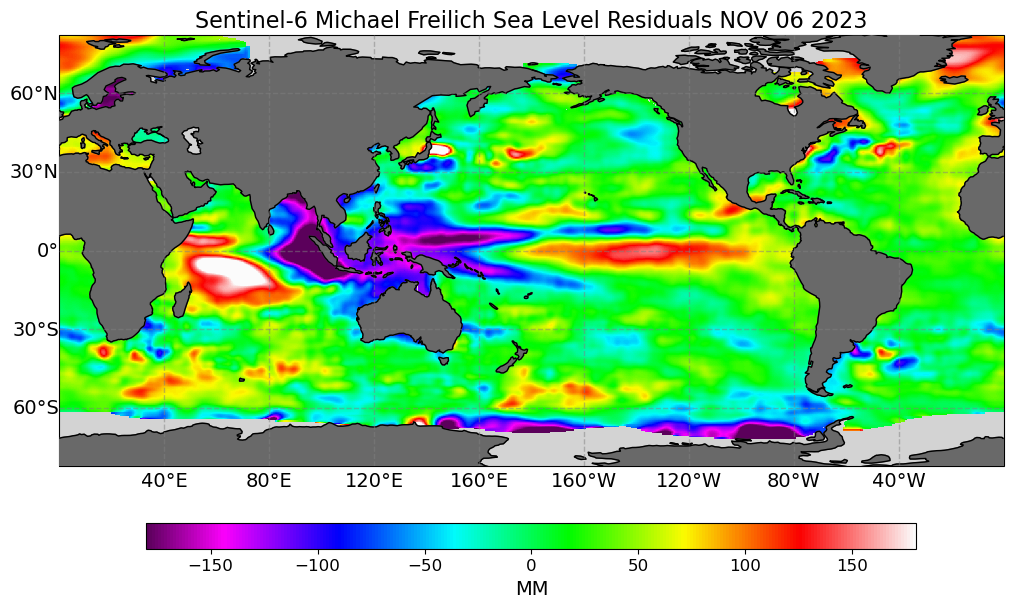

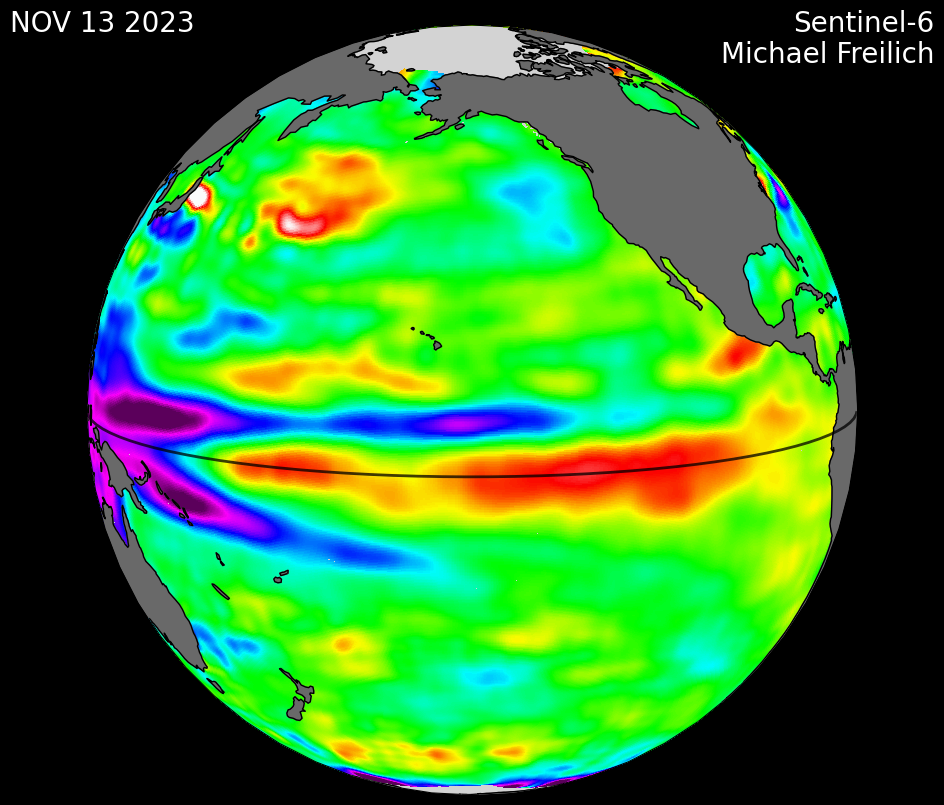

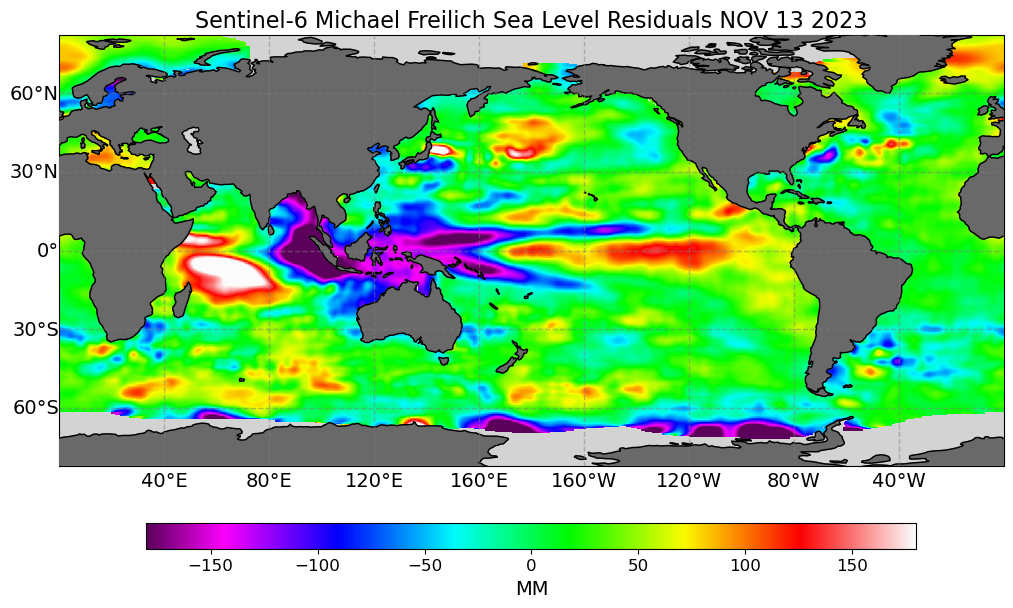

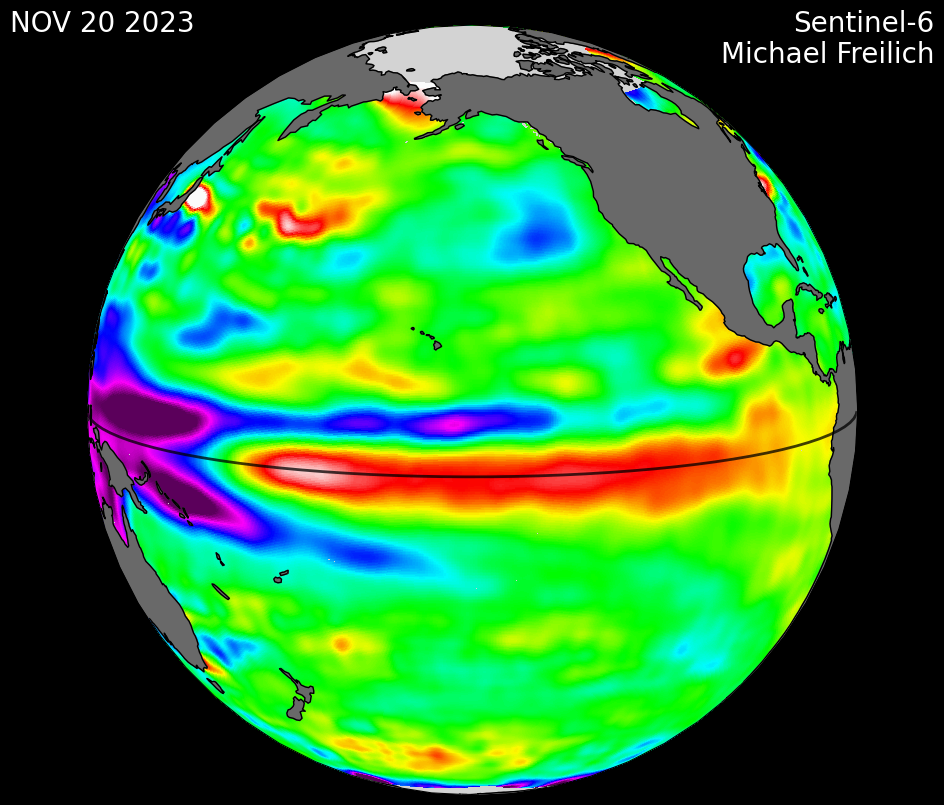

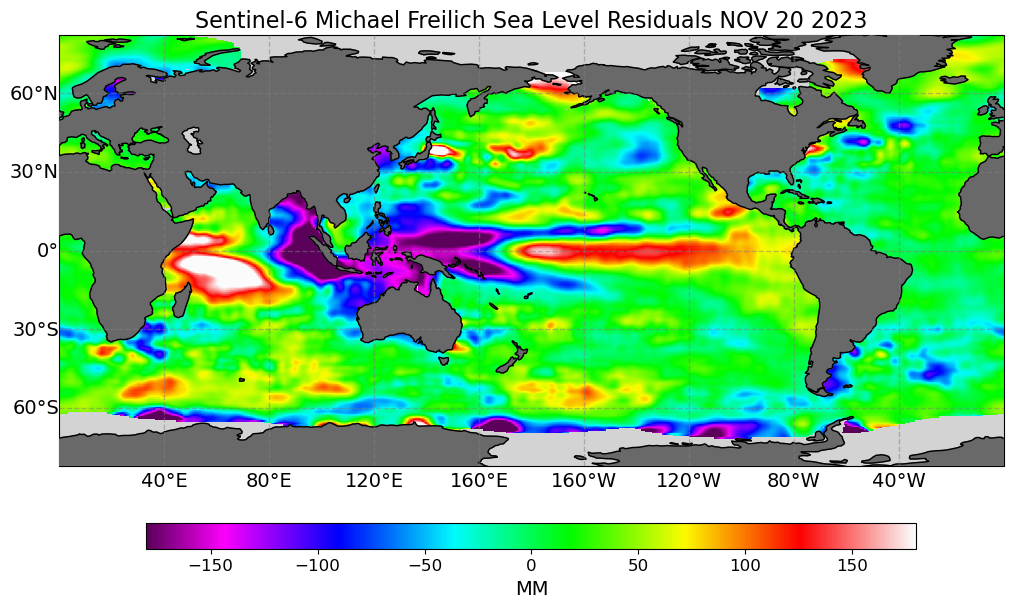

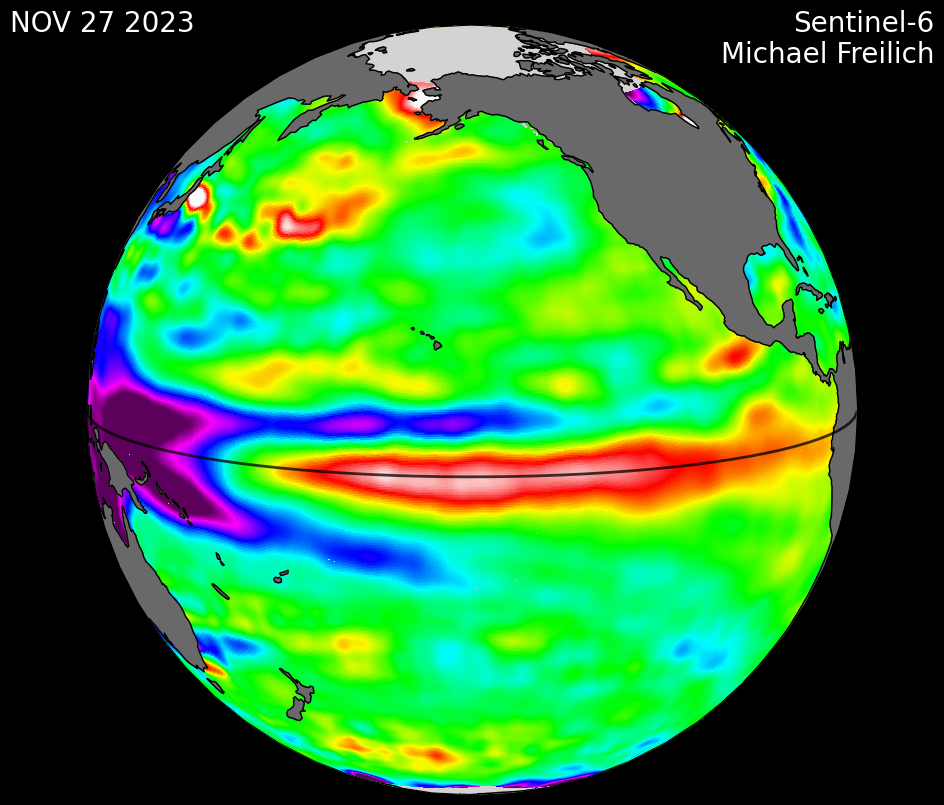

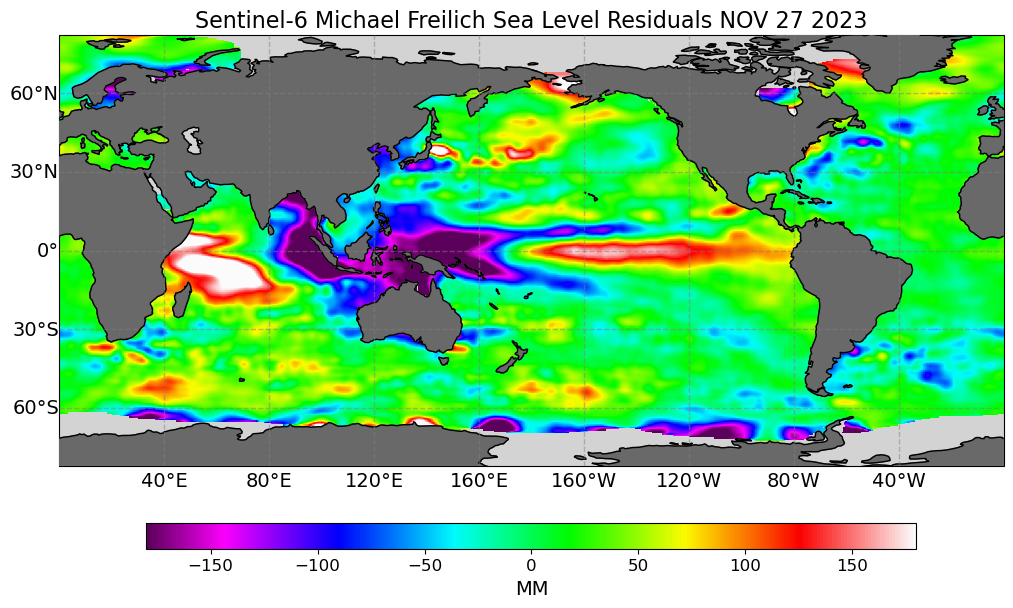

In [6]:
enso_grid_paths = glob(f'/Users/marlis/Developer/SLI/sli_output/ENSO_grids/*.nc')
enso_grid_paths.sort()

outdir = '/Users/marlis/Developer/SLI/sli_output/ENSO_maps'
for f in enso_grid_paths:
    file_name = f.split('/')[-1]
    # if file_name >= 'ENSO_20151025.nc' and file_name <= 'ENSO_20151112.nc':
    if file_name >= 'ENSO_20231101.nc':
        ds = xr.open_dataset(f)
        date_dt = datetime.strptime(str(ds.time.values)[:10], '%Y-%m-%d').date()
        print(date_dt)
        satellite = date_sat_map(date_dt)
        
        plot_orth(ds, date_dt, satellite, outdir) # requires sli-pipeline ENV
        plot_plate(ds, date_dt, satellite, outdir) # requires sli-pipeline ENV
        
        # plot_orth_enso(ds, date_dt, satellite, outdir) # requires simple-gridder ENV

In [10]:
ds.close()

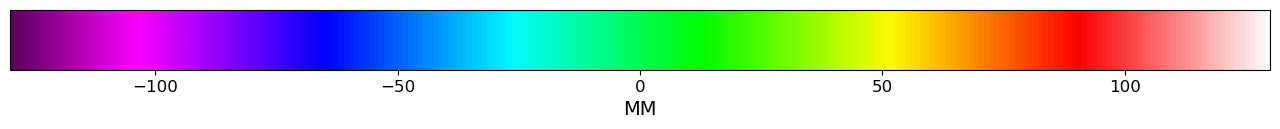

In [28]:

import matplotlib as mpl

fig = plt.figure(figsize=(14,8)).dpi
ax = fig.add_axes([0.05, 0.80, 0.9, 0.075])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', norm=mpl.colors.Normalize(-130, 130),
                               cmap=my_cmap, ticks=[-150, -100, -50, 0, 50, 100, 150])
cb.set_label('MM', fontsize=14)
cb.ax.tick_params(labelsize=12)

In [131]:
ds = xr.open_dataset('/Users/marlis/Developer/Measures-Cloud/alongtrack-delivery/SNTNL-6A/SNTNL-6A-alt_ssh20231105.h5', group='data')
new_ds = xr.Dataset({'ssh': ('time', ds.ssh.values), 'lat': ('time', ds.lats.values), 'lon': ('time', ds.lons.values), 'track_id': ('time', ds.track_id.values)}, {'time': ds.time.values})
new_ds

<xarray.Dataset>
Dimensions:   (time: 55375)
Coordinates:
  * time      (time) float64 1.226e+09 1.226e+09 ... 1.226e+09 1.226e+09
Data variables:
    ssh       (time) float32 0.2213 0.2379 0.2031 ... 0.0374 0.0496 0.0514
    lat       (time) float32 65.04 65.06 65.07 65.09 ... 9.01 9.059 9.108 9.157
    lon       (time) float32 346.7 346.8 346.9 347.0 ... 276.1 276.1 276.1 276.1
    track_id  (time) int32 1100039 1100039 1100039 ... 1100065 1100065 1100065

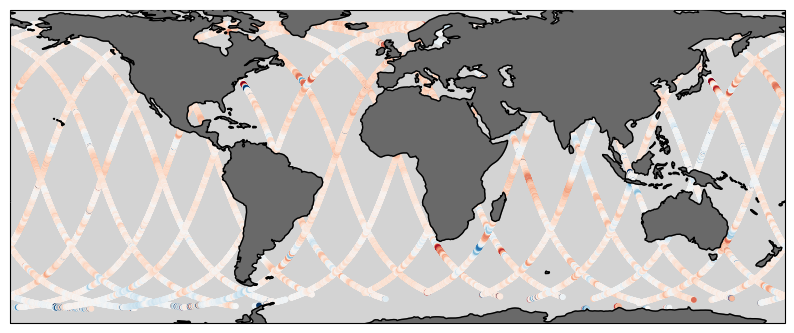

In [132]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(new_ds.lon.values, new_ds.lat.values, transform=ccrs.PlateCarree(), s=10, c=new_ds.ssh.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
ax.coastlines(zorder=11)

In [196]:
ds = xr.open_dataset('/Users/marlis/Developer/Measures-Cloud/alongtrack-delivery/SNTNL-3B/SNTNL-3B-alt_ssh20231103.h5', group='data')
new_ds = xr.Dataset({'ssh': ('time', ds.ssh.values), 'lat': ('time', ds.lats.values), 'lon': ('time', ds.lons.values), 'track_id': ('time', ds.track_id.values)}, {'time': ds.time.values})
new_ds

<xarray.Dataset>
Dimensions:   (time: 42961)
Coordinates:
  * time      (time) float64 1.226e+09 1.226e+09 ... 1.226e+09 1.226e+09
Data variables:
    ssh       (time) float32 0.3084 0.3491 0.2653 ... 0.06944 0.0932 0.09828
    lat       (time) float32 70.46 70.51 70.56 70.67 ... 18.51 18.45 18.39 18.33
    lon       (time) float32 304.7 304.6 304.5 304.3 ... 153.0 153.0 153.0 153.0
    track_id  (time) int32 860003 860003 860003 860003 ... 860032 860032 860032

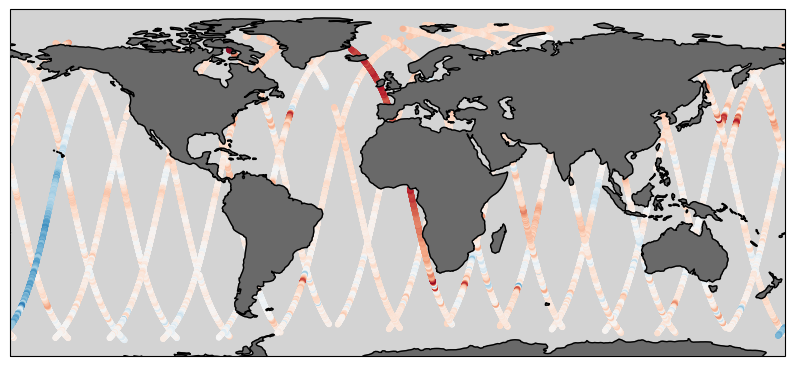

In [142]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(new_ds.lon.values, new_ds.lat.values, transform=ccrs.PlateCarree(), s=10, c=new_ds.ssh.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
ax.coastlines(zorder=11)

Text(0.5, 1.0, 'S3B 2023-11-03 track_id 860028')

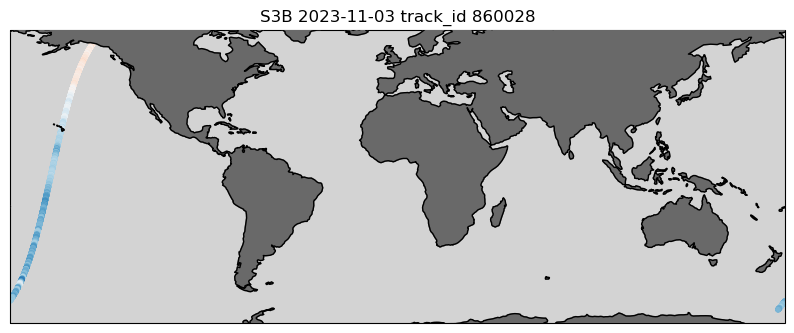

In [181]:
track_ds = new_ds.where(new_ds.track_id == 860028, drop=True)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(track_ds.lon.values, track_ds.lat.values, transform=ccrs.PlateCarree(), s=10, c=track_ds.ssh.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
ax.coastlines(zorder=11)
plt.title('S3B 2023-11-03 track_id 860028')

Text(0.5, 1.0, 'S3B 2023-11-03 track_id 860029')

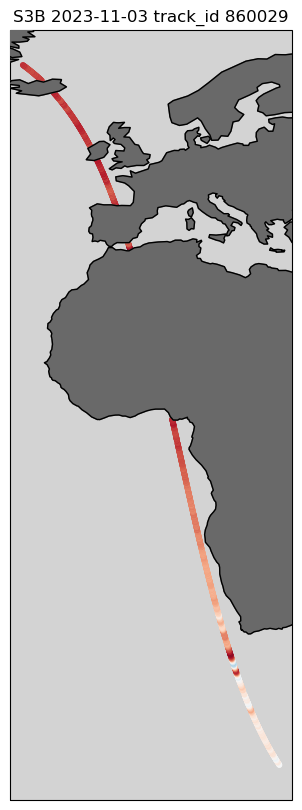

In [182]:
track_ds = new_ds.where(new_ds.track_id == 860029, drop=True)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(track_ds.lon.values, track_ds.lat.values, transform=ccrs.PlateCarree(), s=10, c=track_ds.ssh.values, vmin=-1, vmax=1, cmap='RdBu_r')
ax.add_feature(cfeature.OCEAN, facecolor='lightgrey')
ax.add_feature(cfeature.LAND, facecolor='dimgrey', zorder=10)
ax.coastlines(zorder=11)
plt.title('S3B 2023-11-03 track_id 860029')

In [197]:
drop_ds = ds.where(ds.track_id != 860029, drop=True)
drop_ds = drop_ds.where(drop_ds.track_id != 860028, drop=True)
drop_ds.to_netcdf('test.h5', group='data')